In [134]:
import pandas as pd

In [135]:
import sys
sys.path.append("/private/home/gulordava/tal_data/rnn_agreement/rnnagr/")


In [136]:
import utils
import importlib

utils = importlib.reload(utils)

## Preparing the data

In [137]:
subj_agr_data = pd.read_csv("/private/home/gulordava/tal_data/agr_50_mostcommon_10K.tsv", sep="\t")

Extract only sentences with attractors of the opposite plurality

In [138]:
int_df = subj_agr_data[subj_agr_data.n_intervening == subj_agr_data.n_diff_intervening]

In [139]:
int_df[:2]

,sentence,orig_sentence,pos_sentence,subj,verb,subj_pos,has_rel,has_nsubj,verb_pos,subj_index,verb_index,n_intervening,last_intervening,n_diff_intervening,distance,max_depth,all_nouns,nouns_up_to_verb
0,NNP and NNP VBD prints are not the issue .,a0 and a1 sized prints are not the issue .,NNP CC NNP VBD NNS VBP RB DT NN .,prints,are,NNS,False,False,VBP,5,6,0,na,0,1,0,prints issue,prints
1,a JJ NN ( or JJ or JJ NN ) is nothing but a JJ...,a 0-dimensional manifold ( or differentiable o...,DT JJ NN ( CC JJ CC JJ NN ) VBZ NN CC DT JJ JJ...,manifold,is,NN,False,False,VBZ,9,11,0,na,0,2,0,NN NN nothing space,NN NN


Keeping only sentences where the context is in the LM vocabulary

In [140]:
vocab = open("/private/home/gulordava/edouard_data/enwiki/50K_vocab/vocab.txt").read().split()

In [141]:
def in_vocab(row):
    return all([w in vocab for w in row["orig_sentence"].split()[row["subj_index"] - 1:row["verb_index"]]])

In [143]:
int_df["in_vocab"] = int_df.apply(in_vocab, axis=1)

/private/home/gulordava/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [144]:
int_df[int_df.in_vocab].groupby(["n_intervening"]).size()

n_intervening
0     1175504
1       43023
2        6979
3        1329
4         347
5          94
6          39
7          21
8           2
9           3
11          1
dtype: int64

Keep only sentences where the target verb and its pair form of the opposite number are both in vocabulary

In [145]:
infl_map = utils.gen_inflect_from_vocab("/private/home/gulordava/tal_data/rnn_agreement/data/wiki.vocab")[0]

In [146]:
df = int_df[int_df.in_vocab]
df["alt_verb"] = df.verb.map(infl_map)
df = df[df.alt_verb.isin(vocab)]

/private/home/gulordava/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [147]:
df.groupby("n_intervening").size()

n_intervening
0     1175374
1       43018
2        6979
3        1329
4         347
5          94
6          39
7          21
8           2
9           3
11          1
dtype: int64

Sampling a smaller number of sentences to avoid testing forever

In [148]:
sample_size = 2000
sampled = pd.DataFrame([], columns=int_df.columns)
for i in range(5):
    part = df[df["n_intervening"] == i]
    if len(part) < sample_size:
        sampled = sampled.append(part)
    else:
        sampled = sampled.append(part.sample(sample_size))

In [149]:
sampled.groupby(["n_intervening"]).size()

n_intervening
0    2000
1    2000
2    2000
3    1329
4     347
dtype: int64

Resample again to mix different parts

In [150]:
sampled = sampled.sample(len(sampled))

Write down sentences for LM input and the gold data for evaluation

In [3]:
test_path = "/private/home/gulordava/tal_data/subj_agr"

In [158]:

f = open(test_path + ".text","w")
for s in sampled.orig_sentence:
    f.write(s + " <eos>\n")
f.close()

In [156]:
f = open(test_path + ".gold","w")
for i, v in sampled.iterrows():
    idx = str(v["verb_index"] - 1)
    f.write(idx + "\t" + "\t".join(str(x) for x in v[["verb","alt_verb","n_intervening"]].values) + "\n")
f.close()

In [2]:
path_lm_data = "/private/home/gulordava/edouard_data/enwiki/50K_vocab/"

In [ ]:
!python ~/lm_code/evaluate_last_word.py --data $path_lm_data \
    --checkpoint ~/lstm_hyperparameters_exps/English/models/hidden650_batch128_dropout0.2_lr10.0.pt 
    --cuda --path ~/tal_data/subj_agr --suffix h650

## Evaluating the accuracy on verbs

In [52]:
gold = open(test_path + ".gold").readlines()
sents = open(test_path + ".text").readlines()
output = open(test_path + ".output_median").readlines()

vocab = {w: i for i, w in enumerate(
    open(path_lm_data + "vocab.txt","r").read().split("\t"))}

In [35]:
train = open(path_lm_data + "train.txt").read()

In [36]:
import time
start = time.time()
in_train = {}
for sent in sents:        
    if sent[5:55] in train:
        in_train[sent] = True
        print("in_train")
print(time.time() - start)

in_train
in_train
in_train
in_train
in_train
in_train
in_train
in_train
in_train
in_train
in_train
in_train
in_train
in_train
in_train
in_train
in_train
in_train
in_train
in_train
in_train
in_train
in_train
in_train
in_train
in_train
in_train
in_train
in_train
in_train
in_train
in_train
in_train
in_train
in_train
in_train
in_train
in_train
in_train
in_train
in_train
in_train
in_train
in_train
in_train
in_train
in_train
in_train
in_train
in_train
in_train
in_train
in_train
in_train
in_train
in_train
in_train
in_train
in_train
in_train
in_train
in_train
in_train
in_train
in_train
in_train
in_train
in_train
in_train
in_train
in_train
in_train
in_train
in_train
in_train
in_train
in_train
in_train
in_train
in_train
in_train
in_train
in_train
in_train
in_train
in_train
in_train
in_train
in_train
in_train
in_train
in_train
in_train
in_train
in_train
in_train
in_train
in_train
in_train
in_train
in_train
in_train
in_train
in_train
in_train
in_train
in_train
in_train
in_train
in_train
in_train
i

In [26]:
len(train)

55670264

In [37]:
len(in_train)

187

In [30]:
len(sents)

7676

In [12]:
i

37755558

In [62]:
data = []
new_sents = []
new_gold = []
for g, sent, o in zip(gold, sents, output):
    if not sent in in_train:
        new_sents.append(sent)
        new_gold.append(g)
        scores = o.split()
        idx, verb, alt_verb, n_interv = g.split()
        prob_correct = float(scores[vocab[verb]])
        prob_wrong = float(scores[vocab[alt_verb]])
        data.append([verb, alt_verb, n_interv, prob_correct, prob_wrong])
open(test_path + "_filtered.gold","w").writelines(new_gold)
open(test_path + "_filtered.text","w").writelines(new_sents)


In [54]:
import pandas as pd
from math import sqrt
df = pd.DataFrame(data, columns=["form","alt_form","n_interv","prob_correct","prob_wrong"])
df["acc"] = df.prob_correct > df.prob_wrong
df["se"] = df.groupby("n_interv").acc.transform(lambda x : x.std()/sqrt(len(x)))

df_g = df.groupby("n_interv").agg({"acc": {"mean", "size"}, "se" : "mean"})
df_g

acc                  se
          size      mean        se
n_interv                          
0         1972  0.983266  0.002889
1         1957  0.949923  0.004931
2         1943  0.923314  0.006038
3         1287  0.895882  0.008517
4          330  0.900000  0.016540

In [55]:
df_g = df_g.reset_index()

In [56]:
%load_ext rpy2.ipython

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


In [57]:
%Rpush df_g

   n_interv size       acc          se
1:        0 1972 0.9832657 0.002889320
2:        1 1957 0.9499234 0.004931482
3:        2 1943 0.9233145 0.006038192
4:        3 1287 0.8958819 0.008516635
5:        4  330 0.9000000 0.016539535
    n_interv size       acc          se    model
 1:        0 1972 0.9832657 0.002889320      our
 2:        1 1957 0.9499234 0.004931482      our
 3:        2 1943 0.9233145 0.006038192      our
 4:        3 1287 0.8958819 0.008516635      our
 5:        4  330 0.9000000 0.016539535      our
 6:        0 1972 0.9517000 0.010714286 googleLM
 7:        1 1957 0.7146000 0.022678571 googleLM
 8:        2 1943 0.7107000 0.022576531 googleLM
 9:        3 1287 0.6625000 0.023647959 googleLM
10:        4  330 0.5855000 0.025076531 googleLM
11:        0 1972 0.9974550 0.000000000  numpred
12:        1 1957 0.9848480 0.005612245  numpred
13:        2 1943 0.9451370 0.011390306  numpred
14:        3 1287 0.8975000 0.015178571  numpred
15:        4  330 0.8937820 0.0

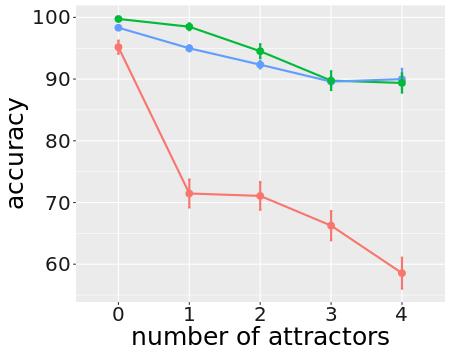

In [59]:
%%R -w 450 -h 350
library(data.table)
library(ggplot2)

df = data.table(df_g)
colnames(df) <- c("n_interv","size","acc","se" )
print(df)
df$model = "our"
df_google = copy(df)
df_google$acc = 1 - c(0.0483, 0.2854, 0.2893, 0.3375, 0.4145)
df_google$se = c(0.069 - 0.027, 0.3298 - 0.2409, 0.3310 - 0.2425, 0.3838 - 0.2911, 0.4636 - 0.3653)/(2 * 1.96)
df_google$model = "googleLM"
df_numpred = copy(df)
df_numpred$acc = 1 - c(0.002545, 0.015152, 0.054863, 0.102500, 0.106218)
df_numpred$se = c(0.0, 0.0236 - 0.0016, 0.07715 - 0.0325, 0.1322 - 0.0727, 0.1369 - 0.07548)/(2*1.96)
df_numpred$model = "numpred"
df = rbind(df, df_google, df_numpred)

print(df)

text = element_text(size=25)
pd <- position_dodge(.0) 

p = ggplot(df, aes(x=n_interv, y=acc*100, color=model, group=model)) + geom_line(size=1.0) + geom_point(stat="identity",position=pd,size=3.0) 
p = p  + xlab("number of attractors") + ylab("accuracy")  
p = p #+ geom_text(aes(label=format(acc*100, digits=3)), vjust=3, colour="white",size=6,position=pd)  
p = p + geom_errorbar(aes(ymin=(acc-se)*100, ymax=(acc+se)*100), width=.1, position=pd, size=1.0) 
p + theme(axis.title.x=text, axis.title.y=text, legend.text=text, axis.text.x=element_text(size=20,color="grey10"), 
          axis.text.y=element_text(size=20,color="grey10"), strip.text=text) + guides(color=FALSE)